# Author: Jakob Adamsson
Built for a Machine learning project at Blekinge Tekniska Högskola, winter 2022

Task: Clean Twitter dataset and apply machinelearning models and evaluate them

Dataset: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

Acronym: JAAD19

Program: DVAMI20h

In [1]:
# For model building
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score as fs
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import numpy as np
import datacleaning as dc
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway

# For data cleaning
import nltk as sw  # sw for stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

sw.download("stopwords")
sw.download("punkt")

[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Clean the data
These are the steps i will use during data cleaning phase:
1. Analyze the data, find outliers and remove them also remove useless columns
2. See if there is a significant amount of unicode characters such as #, [], \n \r digits in words etc, if it is, replace them with ""(empty space)
3. Remove stop words, stop words does not usually have a weight when using NLP and i will use a lib for that
4. Apply a stemming algorithm on the dataset so that words that mean the same thing gets replaced by another more general word. Ex am, are, is $\Rightarrow$ be

#### Read the data into dataframe using Pandas
Select only the target and text column

In [2]:

df = pd.read_csv("dataset/data.csv")
df = df[["text", "target"]]
df.loc[df["target"] == 4, "target"] = 1
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


#### Define the functions that will be applied on the data to clean it

In [6]:
def clean_text(df: pd.DataFrame, column: str) -> pd.DataFrame:
    df[column] = df[column].str.replace(r"@\w+", "")
    df[column] = df[column].str.replace(r"\d", "")
    df[column] = df[column].str.replace(r"\n", "")
    df[column] = df[column].str.replace(r"\[.*?\]", "")
    df[column] = df[column].str.replace(r"https?:\/\/.*[\r\n]*", "", case=False)
    df[column] = df[column].str.replace(r"#\w+", "", case=False)
    df[column] = df[column].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    return df


def remove_stop_words(df: pd.DataFrame, column: str, language: str = "english") -> pd.DataFrame:
    """Remove stopwords from each tweet, since stopwords does not ususally have a large impact when training the model"""

    stop_words = stopwords.words(language)
    df[column] = df[column].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    return df


def stem_tweets(df: pd.DataFrame, column: str) -> str:
    stemmer = PorterStemmer()
    df[column] = df[column].apply(lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)]))
    return df


def getDataFrame(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[["text", "target"]]

    # Remove tweets that occurs more than once
    df.drop_duplicates(subset=["text"])
    df = stem_tweets(df, "text")
    df = clean_text(df, "text")
    df = remove_stop_words(df, "text", "english")
    return df
def remove_low_freq_words(df, column, threshold):
    df.dropna(axis=0, inplace=True)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(df[column])
    
    # Get the feature names
    feature_names = vectorizer.vocabulary_
    
    #
    tfidf = vectorizer.transform(df[column]).toarray()
    
    filtered_words = [[word for word, value in zip(feature_names, values) if value >= threshold] for values in tfidf]  
    
    filtered_text = [' '.join(words) for words in filtered_words]

    # Replace the text in the specified column with the filtered text
    df[column] = filtered_text

    return df  

#### Apply the methods on the dataset

In [7]:
# Remove tweets that occurs more than once
df.drop_duplicates(subset=["text"], inplace=True)

# Apply the methods
df = stem_tweets(df, "text")
df = clean_text(df, "text")
df = remove_stop_words(df, "text", "english")

df_chuncks = pd.read_csv("dataset/data_updated.csv", chunksize=50000)
df_list = []
for chunck in df_chuncks:
    temp = remove_low_freq_words(chunck, "text", 0.3)
    df_list.append(temp)

df = pd.concat(df_list)

#### Save the new dataframe in the dataset folder
This is done because i the cleaningprocess takes a while and i dont want to repeat it everytime i run this program

In [8]:
df.to_csv("data_updated.csv", index=False, header=True)

#### Load the new updated dataset

In [10]:
df = pd.read_csv("data_updated.csv")
print("New dataset loaded, shape: ", df.shape)

New dataset loaded, shape:  (1581093, 2)


#### Check if the data is balanced

In [11]:
df_1 = df[df["target"] == 1]
df_0 = df[df["target"] == 0]
print(f"Amount of tweets that are positive: {len(df_1)}\nAmount of tweets that are nagative: {len(df_0)}")

print(f"Positive tweets: {len(df_1)/(len(df_1) + len(df_0))}%\nNegative tweets: {len(df_0)/(len(df_1) + len(df_0))}%")

# LÄGG IN ÖVER
df.dropna(axis=0, inplace=True)



Amount of tweets that are positive: 791094
Amount of tweets that are nagative: 789999
Positive tweets: 0.5003462794408678%
Negative tweets: 0.4996537205591322%


We can see that the data is balanced, there is therefore no need to remove any values or anything like that

# Build the models
1. Pick a model
2. Build a model and evaluate
3. Repeat untill three models are done

Split the dataset into train and test sets, splitting at 1/5 of the whole dataset

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(df["text"], df["target"], test_size=0.2, random_state=42)

#### Vectorize and reshape the train and testdata(tokenize)
When the Train and Test sets are vectorized, the result of that operation will generate a Numpy array that spilts the text into individual words and calculates the frequency in the document.
The higher of a value, the more important is it to the tweet.

In [21]:
    # See the distribution of the data
    print(Y_train.value_counts())
    
    # Vectorize the train and test data
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Ensure that all train and test data has the same shape
    X_train = np.reshape(X_train, (len(Y_train), X_test.shape[1]))
    X_test = np.reshape(X_test, (len(Y_test), X_test.shape[1]))

1    631865
0    631848
Name: target, dtype: int64


## Building the models

In [22]:
class PredictDisaster:
    def __init__(self, algorithm, X_train, Y_train, X_test, Y_test, name):
        self.algorithm = algorithm
        print(f"Training started...({name})")
        self.fit_data(X_train, Y_train)
        print(f"Training finished without grid search...({name})")
        self.pred = self.predict_data(X_test)
        print(f"Prediction finished without grid search...({name})")
        self.acc = self.acc_score(Y_test)
        print(f"Accuracy score calculated...({name})")
        self.cm = self.conf_mat(Y_test)
        print(f"Confusion matrix calculated...({name})")
        self.fs = self.f1_score(X_test, Y_test)
        print(f"F1 score calculated...({name})\n")
    
    def fit_data(self,X_train, Y_train):
        self.algorithm.fit(X_train, Y_train)
        
    def predict_data(self, X_test):
        return self.algorithm.predict(X_test)
    
    def acc_score(self, Y_test):
        return accuracy_score(Y_test, self.pred)
    
    def conf_mat(self, Y_test):
        return cm(Y_test, self.pred)
    
    def f1_score(self, X_test, Y_test):
        kf = KFold(n_splits=5)
        f1_scores = []
        for train_index, test_index in kf.split(X_test):
            x_train, x_test = X_test[train_index], X_test[test_index]
            y_train, y_test = Y_test.to_numpy()[train_index], Y_test.to_numpy()[test_index]
            self.algorithm.fit(x_train, y_train)
            pred = self.algorithm.predict(x_test)
            f1_scores.append(fs(y_test, pred))
        return f1_scores
    
    def print_methods(self):
        print("""
              1. fit_data(X_train, Y_train)
              2. predict_data(X_test)
              3. acc_score(Y_test)
              4. conf_mat(Y_test)
              5. f1_score(Y_test)
              """)
    



#### Initital idea is to have simple hyperparameters to see what result that produces

In [23]:
# Create the models
lr = LogisticRegression(solver="sag", max_iter=100000)
gbc = GradientBoostingClassifier()
svm = SGDClassifier(loss="hinge")
mnb = MultinomialNB()

# Predict the disaster
lr_C = PredictDisaster(lr, X_train, Y_train, X_test, Y_test, "LogisticRegression")
gbc_C = PredictDisaster(gbc, X_train, Y_train, X_test, Y_test, "GradientBoostingClassifier")
svm_C = PredictDisaster(svm, X_train, Y_train, X_test, Y_test, "SVM")
mnb_C = PredictDisaster(mnb, X_train, Y_train, X_test, Y_test, "MultinomialNB")

Training started...(LogisticRegression)
Training finished without grid search...(LogisticRegression)
Prediction finished without grid search...(LogisticRegression)
Accuracy score calculated...(LogisticRegression)
Confusion matrix calculated...(LogisticRegression)
F1 score calculated...(LogisticRegression)

Training started...(GradientBoostingClassifier)
Training finished without grid search...(GradientBoostingClassifier)
Prediction finished without grid search...(GradientBoostingClassifier)
Accuracy score calculated...(GradientBoostingClassifier)
Confusion matrix calculated...(GradientBoostingClassifier)
F1 score calculated...(GradientBoostingClassifier)

Training started...(SVM)
Training finished without grid search...(SVM)
Prediction finished without grid search...(SVM)
Accuracy score calculated...(SVM)
Confusion matrix calculated...(SVM)
F1 score calculated...(SVM)

Training started...(MultinomialNB)
Training finished without grid search...(MultinomialNB)
Prediction finished without

#### Pickle the models, saved models are located in "pickled_models"

In [24]:
model_list = [lr_C, gbc_C, svm_C, mnb_C]
model_list_names = ["LogisticRegression", "GradientBoostingClassifier", "SVM", "MultinomialNB"]
for i in range(len(model_list)):
    with open(f"pickled_models/{model_list_names[i]}.pickle", "wb") as f:
        pickle.dump(model_list[i], f)

#### Load the saved models for faster usage. Start here if you dont want to run each cell above

In [25]:
model_list_names = ["LogisticRegression", "GradientBoostingClassifier", "SVM", "MultinomialNB"]
for name in model_list_names:
    with open(f"pickled_models/{name}.pickle", "rb") as f:
        model = pickle.load(f)
        if name == "LogisticRegression":
            lr_C = model
        elif name == "GradientBoostingClassifier":
            gbc_C = model
        elif name == "SVM":
            svm_C = model
        elif name == "MultinomialNB":
            mnb_C = model

#### Print the accuracy score

In [26]:
print(f"Logistic Regression accuracy score: {lr_C.acc}\nGradient Boosting Classifier accuracy score: {gbc_C.acc}\nSVM accuracy score: {svm_C.acc}\nMultinomialNB accuracy score: {mnb_C.acc}")

Logistic Regression accuracy score: 0.9352671011524741
Gradient Boosting Classifier accuracy score: 0.5365952476664061
SVM accuracy score: 0.8426766773547221
MultinomialNB accuracy score: 0.9473141117149739


#### Plot of Logistic Regression Confusion Matrix

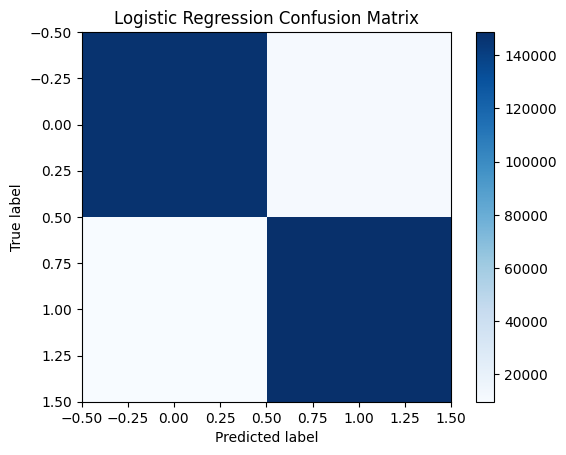

[[146752  10777]
 [  9674 148726]]


In [27]:

plt.imshow(lr_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()
print(f"{lr_C.cm}")


#### Plot of Logistic Regression Confusion Matrix

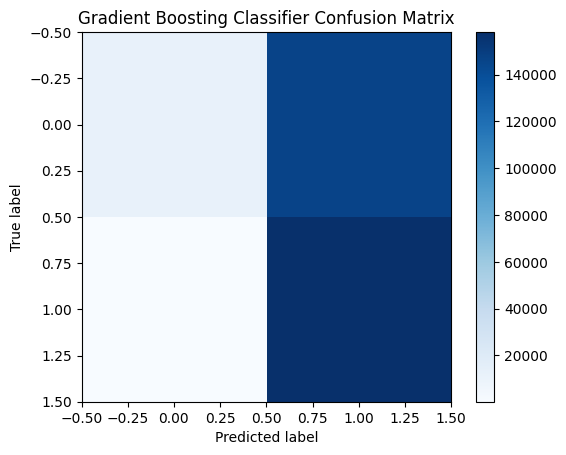

[[ 11364 146165]
 [   238 158162]]


In [28]:
plt.imshow(gbc_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Gradient Boosting Classifier Confusion Matrix")
plt.show()
print(f"{gbc_C.cm}")

#### Plot of Logistic Regression Confusion Matrix

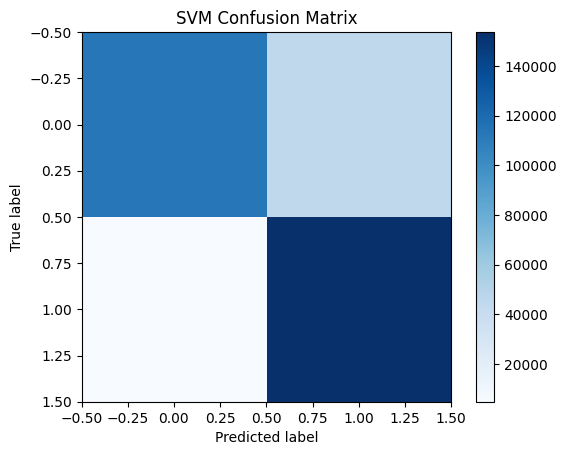

[[112599  44930]
 [  4773 153627]]


In [29]:
plt.imshow(svm_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("SVM Confusion Matrix")
plt.show()
print(f"{svm_C.cm}")

#### Plot of Logistic Regression Confusion Matrix

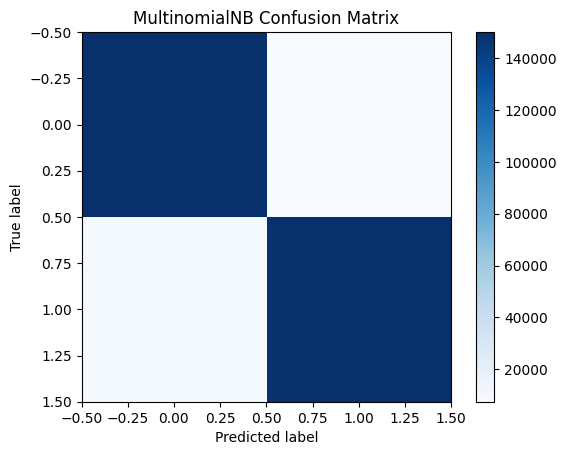

[[150126   7403]
 [  9242 149158]]


In [30]:
plt.imshow(mnb_C.cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("MultinomialNB Confusion Matrix")
plt.show()
print(f"{mnb_C.cm}")

#### Lets analyze the f1-score

In [31]:
print(f"Logistic Regression F1 score: {lr_C.fs}\nGradient Boosting Classifier F1 score: {gbc_C.fs}\nSVM F1 score: {svm_C.fs}\nMultinomialNB F1 score: {mnb_C.fs}")

Logistic Regression F1 score: [0.9089501393620316, 0.9087302826799937, 0.9094721148022179, 0.9106805146488917, 0.905525735121516]
Gradient Boosting Classifier F1 score: [0.6856446586657178, 0.6829991451419172, 0.6829700360776859, 0.6855191433434596, 0.6802193277128801]
SVM F1 score: [0.8593059409115625, 0.8553522186011533, 0.8572586165947162, 0.8644036826200014, 0.842982033454946]
MultinomialNB F1 score: [0.9216209811201516, 0.9217917097621131, 0.921681780708986, 0.9227169238552998, 0.9196310092887177]


#### Im not quite happy with the F1-scores SVM and Gradient Boosting Classifier got, i will now try to tweek some hyperparameters to see if the result will be improved or not.
The goal is to have each algorithm performing with a F1-score above 0.9.

In [33]:

param_grid_svm = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'alpha': [0.0001, 0.001, 0.01],
              'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}


svm = SGDClassifier()
kFold = kfold = KFold(n_splits=5, shuffle=True, random_state=42)



grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=kFold, scoring="f1", n_jobs=7)
print("Training started...(SVM)")
grid_search_svm.fit(X_train, Y_train)
print("Training finished...(SVM)")
print("=====================================")
print("Best parameters:", grid_search_svm.best_params_)
print("Best F1-score:", grid_search_svm.best_score_)
print("=====================================")
print("Initilizing the best model...")
best_svm = SGDClassifier(**grid_search_svm.best_params_)
print("Training started...(SVM best model)")
best_svm.fit(X_train, Y_train)
print("Training finished...(SVM best model)")
f1_scores_svm = []
accuracys_svm = []
for train_index, test_index in kFold.split(X_test):
    X_train_fold, X_test_fold = X_test[train_index], X_test[test_index]
    Y_train_fold, Y_test_fold = Y_test.to_numpy()[train_index], Y_test.to_numpy()[test_index]
    best_svm.fit(X_train_fold, Y_train_fold)
    Y_pred = best_svm.predict(X_test_fold)
    accuracys_svm.append(accuracy_score(Y_test_fold, Y_pred))
    f1_scores_svm.append(fs(Y_test_fold, Y_pred))
test_predictions = best_svm.predict(X_test)
print("Predictions finished...(SVM best model)")
test_f1 = fs(Y_test, test_predictions)
print("test F1-score:", test_f1)
print("All F1-scores:", f1_scores_svm)
print("All accuracys:", accuracys_svm)

Training started...(SVM)
Training finished...(SVM)
Best parameters: {'alpha': 0.0001, 'l1_ratio': 0, 'loss': 'modified_huber', 'penalty': 'elasticnet'}
Best F1-score: 0.9116073299027352
Initilizing the best model...
Training started...(SVM best model)
Training finished...(SVM best model)
Predictions finished...(SVM best model)
test F1-score: 0.9430684827493924
All F1-scores: [0.9038526894676677, 0.9050361055776892, 0.9004490671440256, 0.9026998705541515, 0.9029652070136784]
All accuracys: [0.9014971670939765, 0.9034279745513246, 0.8979045991200583, 0.9000728009369164, 0.8996280762839282]


#### The F1-score and accuracy improved, now the F1-score is above 0.9 where i want it.

Lets save the new model

In [40]:
# Update the svm_C object
svm_C.algorithm = best_svm
svm_C.fs = f1_scores_svm

# Save the new model
with open(f"pickled_models/SVM.pickle", "wb") as f:
    pickle.dump(svm_C, f)

print("Model saved!")

Model saved!


In [43]:
param_grid_gbd = {'loss': ['log_loss', 'exponential'],
                  'learning_rate': [0.1, 1],
                  'n_estimators': [100, 200]}

gbd = GradientBoostingClassifier()
kFold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_gbd = GridSearchCV(gbd, param_grid_gbd, cv=kFold, scoring="f1", n_jobs=7)
print("Training started...(GBD)")
grid_search_gbd.fit(X_train, Y_train)
print("Training finished...(GBD)")
print("=====================================")
print("Best parameters:", grid_search_gbd.best_params_)
print("Best F1-score:", grid_search_gbd.best_score_)
print("=====================================")
print("Initilizing the best model...")
best_gbd = GradientBoostingClassifier(**grid_search_gbd.best_params_)
print("Training started...(GBD best model)")
best_gbd.fit(X_train, Y_train)
print("Training finished...(GBD best model)")
f1_scores_gbd = []
accuracys_gbd = []
for train_index, test_index in kFold.split(X_test):
    X_train_fold, X_test_fold = X_test[train_index], X_test[test_index]
    Y_train_fold, Y_test_fold = Y_test.to_numpy()[train_index], Y_test.to_numpy()[test_index]
    best_gbd.fit(X_train_fold, Y_train_fold)
    Y_pred = best_gbd.predict(X_test_fold)
    accuracys_gbd.append(accuracy_score(Y_test_fold, Y_pred))
    f1_scores_gbd.append(fs(Y_test_fold, Y_pred))
test_predictions = best_gbd.predict(X_test)
print("Predictions finished...(GBD best model)")
test_f1 = fs(Y_test, test_predictions)
print("test F1-score:", test_f1)
print("All F1-scores: ", f1_scores_gbd)
print("All accuracys: ", accuracys_gbd)

Training started...(GBD)


#### Lets analyse the F1-scores using kruskals test

In [41]:
def k_test(algo1_fs: float, algo2_fs: float, algo3_fs: float, algo4_fs: float) -> None:

    # Set up the hypotheses
    H0 = "There is no statistical significant difference between the f1-scores"
    H1 = "There is a statistical significant difference between the f1-scores"

    # Significance level
    alpha = 0.05

    t_stat, p_value = kruskal(algo1_fs, algo2_fs, algo3_fs, algo4_fs)

    # Check p_value against significance level(alpha)
    if p_value < alpha:
        print(f"{H1} -> p_value = {p_value}")

    else:
        print(f"{H0} -> p_value = {p_value}")
    
k_test(lr_C.fs, gbc_C.fs, svm_C.fs, mnb_C.fs)

There is a statistical significant difference between the f1-scores -> p_value = 0.0004707189529993288


#### Lets analyze the F1-scores using anova oneway test    


In [42]:
def f_oneway_test(algo1_fs: float, algo2_fs: float, algo3_fs: float, algo4_fs: float) -> None:
    
    # Set up the hypotheses
    H0 = "There is no statistical significant difference between the f1-scores"
    H1 = "There is a statistical significant difference between the f1-scores"
    
    # Use the ANOVA test to determine whether the means of the F1 scores are significantly different
    statistic, p_value = f_oneway(algo1_fs, algo2_fs, algo3_fs, algo4_fs)

    # Set the significance level
    alpha = 0.05

    # Check the p-value against the significance level
    if p_value < alpha:
        print(f"{H1} -> p_value = {p_value}")

    else:
        print(f"{H0} -> p_value = {p_value}")
        
f_oneway_test(lr_C.fs, gbc_C.fs, svm_C.fs, mnb_C.fs)

There is a statistical significant difference between the f1-scores -> p_value = 7.483806533287154e-29
